# CT 스캔에서 3D 이미지 분류

**Author:** [Hasib Zunair](https://twitter.com/hasibzunair)<br>
**Date created:** 2020/09/23<br>
**Last modified:** 2020/09/23<br>
**Description:** 3D 컨벌루션 신경망을 훈련시켜 폐렴의 존재를 예측합니다.

## 소개

이 예에서는 3D CNN(컨볼루션 신경망)을 구축하는 데 필요한 단계를 보여줍니다.<br>
컴퓨터 단층촬영(CT) 스캔에서 바이러스성 폐렴의 존재를 예측하기 위해.<br>
2D CNN은 일반적으로 RGB 이미지(3개 채널)를 처리하는 데 사용됩니다. <br>
3D CNN은 단순히 3D입니다.<br>
같음: 3D 볼륨 또는 2D 프레임 시퀀스(예: CT 스캔의 슬라이스)를 입력으로 사용합니다.<br>
3D CNN은 체적 데이터에 대한 표현을 학습하기 위한 강력한 모델입니다.<br>

## 참조

- [A survey on Deep Learning Advances on Different 3D DataRepresentations](https://arxiv.org/pdf/1808.01462.pdf)
- [VoxNet: A 3D Convolutional Neural Network for Real-Time Object Recognition](https://www.ri.cmu.edu/pub_files/2015/9/voxnet_maturana_scherer_iros15.pdf)
- [FusionNet: 3D Object Classification Using MultipleData Representations](http://3ddl.cs.princeton.edu/2016/papers/Hegde_Zadeh.pdf)
- [Uniformizing Techniques to Process CT scans with 3D CNNs for Tuberculosis Prediction](https://arxiv.org/abs/2007.13224)

## 설정

In [ ]:
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

## MosMedData 다운로드: COVID-19 관련 결과를 사용한 흉부 CT 스캔

이 예에서는 하위 집합을 사용합니다.
[MosMedData: COVID-19 관련 결과를 사용한 흉부 CT 스캔](https://www.medrxiv.org/content/10.1101/2020.05.20.20100362v1).
이 데이터 세트는 COVID-19 관련 발견과 그러한 발견이 없는 폐 CT 스캔으로 구성됩니다.

CT 스캔의 관련 방사선학적 소견을 레이블로 사용하여 구축할 것입니다.
바이러스성 폐렴의 존재를 예측하는 분류기.
따라서 작업은 이진 분류 문제입니다.

In [ ]:
# Download url of normal CT scans.
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
filename = os.path.join(os.getcwd(), "CT-0.zip")
keras.utils.get_file(filename, url)

# Download url of abnormal CT scans.
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"
filename = os.path.join(os.getcwd(), "CT-23.zip")
keras.utils.get_file(filename, url)

# Make a directory to store the data.
os.makedirs("MosMedData")

# Unzip data in the newly created directory.
with zipfile.ZipFile("CT-0.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

with zipfile.ZipFile("CT-23.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

## 데이터 로드 및 전처리

파일은 확장자가 .nii인 Nifti 형식으로 제공됩니다. 스캔을 읽기 위해 `nibabel` 패키지를 사용합니다.
`pip install nibabel`을 통해 패키지를 설치할 수 있습니다.
CT 스캔은 원시 복셀 강도를 Hounsfield 단위(HU)로 저장합니다.
이 데이터 세트에서 범위는 -1024에서 2000 이상입니다.
400 이상은 방사성 강도가 다른 뼈이므로 이것을 더 높은 경계로 사용합니다.
-1000에서 400 사이의 임계값은 일반적으로 CT 스캔을 정규화하는 데 사용됩니다.

데이터를 처리하기 위해 다음을 수행합니다.

* 먼저 볼륨을 90도 회전하므로 방향이 고정됩니다.
* HU 값을 0과 1 사이로 조정합니다.
* 너비, 높이, 깊이의 크기를 조정합니다.

여기에서 데이터를 처리하기 위한 몇 가지 도우미 함수를 정의합니다.
이러한 함수는 훈련 및 검증 데이터 세트를 구축할 때 사용됩니다.

In [ ]:
!pip install nibabel

In [ ]:
import nibabel as nib

from scipy import ndimage


def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume


클래스 디렉토리에서 CT 스캔의 경로를 읽어봅시다.

In [ ]:
# Folder "CT-0" consist of CT scans having normal lung tissue,
# no CT-signs of viral pneumonia.
normal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-0", x)
    for x in os.listdir("MosMedData/CT-0")
]
# Folder "CT-23" consist of CT scans having several ground-glass opacifications,
# involvement of lung parenchyma.
abnormal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-23", x)
    for x in os.listdir("MosMedData/CT-23")
]

print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))


## 훈련 및 검증 데이터세트 구축
클래스 디렉토리에서 스캔을 읽고 레이블을 지정하십시오.<br>
128x128x64 모양이 되도록 스캔을 다운샘플링합니다.<br>
원시 HU 값을 0~1 범위로 다시 조정합니다.<br>
마지막으로 데이터 세트를 학습 및 유효성 검사 하위 집합으로 분할합니다.

In [ ]:
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])

print(normal_scans.shape)

# For the CT scans having presence of viral pneumonia
# assign 1, for the normal ones assign 0.
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

# Split data in the ratio 70-30 for training and validation.
x_train = np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0)
y_train = np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0)
x_val = np.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0)
y_val = np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

## 데이터 보강

CT 스캔은 또한 훈련 중에 임의의 각도로 회전하여 증대됩니다.<br>
데이터는 '(샘플, 높이, 너비, 깊이)' 모양의 랭크 3 텐서에 저장되므로 데이터에 대해 3D 컨볼루션을 수행할 수 있도록 축 4에 크기 1의 차원을 추가합니다.<br>
따라서 새 모양은 `(샘플, 높이, 너비, 깊이, 1)`입니다.<br>
다양한 종류의 전처리 및 증강 기술이 있으며 이 예에서는 시작하는 데 몇 가지 간단한 기술을 보여줍니다.

In [17]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


학습 데이터 로더와 검증 데이터 로더를 정의하는 동안 학습 데이터가 전달되고 볼륨을 다른 각도로 무작위로 회전시키는 Augmentation 기능이 있습니다. <br>
훈련 데이터와 검증 데이터 모두 이미 0과 1 사이의 값을 갖도록 다시 조정되었습니다.

In [18]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

증강 CT 스캔을 시각화합니다.

(2, 128, 128, 64, 1)
Dimension of the CT scan is: (128, 128, 64, 1)


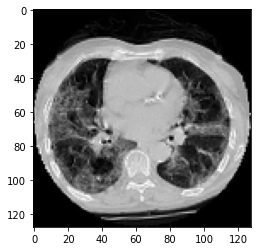

In [31]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
print(images.shape)
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

CT 스캔에는 많은 슬라이스가 있으므로 슬라이스의 몽타주를 시각화해 보겠습니다.

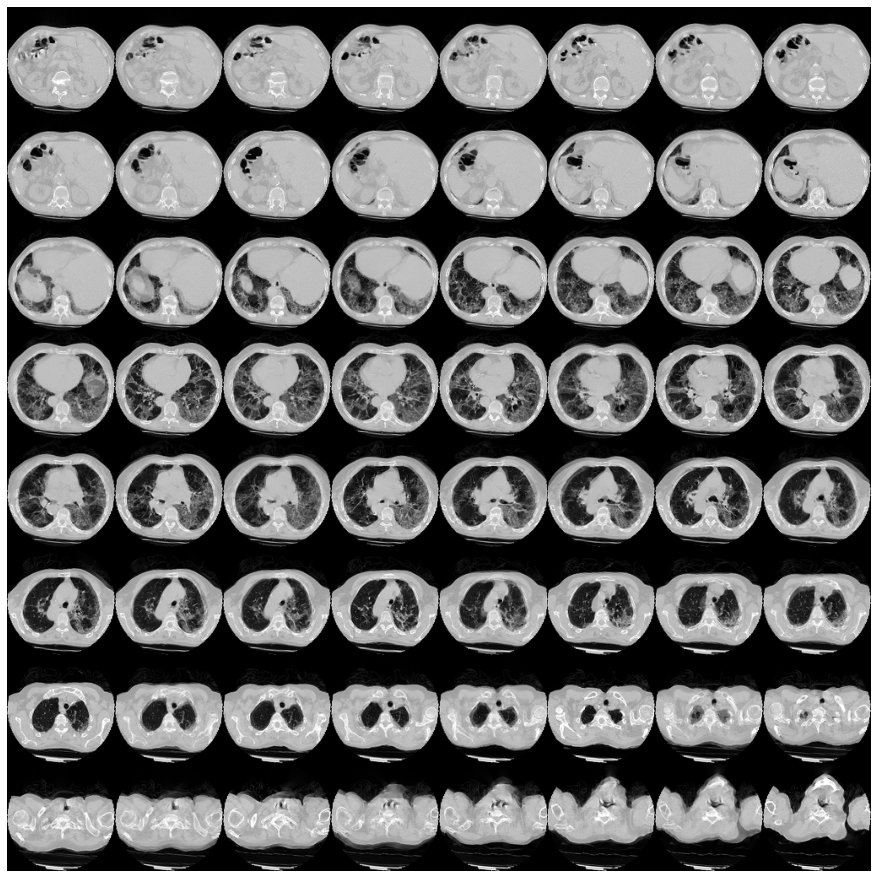

In [33]:

def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(8, 8, 128, 128, image[:, :, :])  # (128, 128, 40)

## 3D 컨벌루션 신경망 정의

모델을 더 쉽게 이해할 수 있도록 블록으로 구성합니다. <br>
이 예제에서 사용된 3D CNN의 아키텍처는 [본 논문](https://arxiv.org/abs/2007.13224)을 기반으로 합니다.

In [39]:
x = tf.constant(np.arange(2*9*4).reshape(2,9,4), dtype="float32")
x = layers.Conv1D(filters=5, kernel_size=3)(x)
print(x.shape)

(2, 7, 5)


In [43]:
x = tf.constant(np.arange(2*4*4*3).reshape(2,4,4,3), dtype="float32")
x = layers.Conv2D(filters=5, kernel_size=2)(x)
print(x.shape)

(2, 3, 3, 5)


In [50]:
x = tf.constant(np.arange(2*4*4*5*3).reshape(2,4,4,5,3), dtype="float32")
x = layers.Conv3D(filters=5, kernel_size=2)(x)
print(x.shape)

(2, 3, 3, 4, 5)


In [51]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))                           # (2,128,128,64,1)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)   # (2,126,126,62,64)
    x = layers.MaxPool3D(pool_size=2)(x)                                      # (2,63,63,31,64)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)        # (2,61,61,29,64)
    x = layers.MaxPool3D(pool_size=2)(x)                                      # (2,30,30,14,64)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)       # (2,28,28,12,128)
    x = layers.MaxPool3D(pool_size=2)(x)                                      # (2,14,14,6,128)
    x = layers.BatchNormalization()(x) 

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)       # (2,12,12,4,256)
    x = layers.MaxPool3D(pool_size=2)(x)                                      # (2,6,6,2,256)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)                                    # (2,256)
    x = layers.Dense(units=512, activation="relu")(x)                         # (2,256)(256,512)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)                  # (2,512)(512,1) => (2,1)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d_5 (Conv3D)           (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 31, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 31, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_6 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                             

## 훈련 모델

In [ ]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100


453 / 5,000
번역 결과
샘플 수가 매우 적고(단 200개) 임의의 시드를 지정하지 않는다는 점에 유의하는 것이 중요합니다.<br>
따라서 결과에 상당한 차이가 있을 것으로 예상할 수 있습니다.<br>
1000개 이상의 CT 스캔으로 구성된 전체 데이터 세트는 [여기](https://www.medrxiv.org/content/10.1101/2020.05.20.20100362v1)에서 찾을 수 있습니다. <br>전체 데이터 세트를 사용하여 83%의 정확도를 달성했습니다.<br>
분류 성능에서 6-7%의 변동성이 두 경우 모두에서 관찰됩니다. 

## 모델 성능 시각화

여기에 훈련 및 검증 세트에 대한 모델 정확도와 손실이 표시됩니다.<br>
유효성 검사 세트가 클래스 균형을 이루기 때문에 정확도는 모델 성능에 대한 편견 없는 표현을 제공합니다.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

## 단일 CT 스캔으로 예측

In [ ]:
# Load best weights.
model.load_weights("3d_image_classification.h5")
prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )